In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import skew
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV
import lazypredict
from lazypredict.Supervised import LazyClassifier
import tensorflow as tf
import keras
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import MeanSquaredLogarithmicError
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix
# import graphviz
from sklearn.tree import export_graphviz
import six
import sys
from six import StringIO
# import pydotplus
# from IPython.display import Image
import pickle 

## Importing the dataset

In [14]:
filePath = r"O:\VIT\Winter Semester 2022-2023\Data Visualization\Project\bankdataset.csv"
originalDF = pd.read_csv(filePath)
originalDF.head()

,Unnamed: 0,b_tgt,int_tgt,cnt_tgt,cat_input1,cat_input2,demog_age,demog_ho,demog_homeval,demog_inc,...,rfm7,rfm8,rfm9,rfm10,rfm11,rfm12,demog_genf,demog_genm,account,dataset
0,1,1,7000.00,NaN,X,A,NaN,0,57600.00,52106.00,...,4,6,5,20,9,92,0,1,100000001.00,1
1,2,1,7000.00,2.00,X,A,NaN,0,57587.00,52106.00,...,4,6,5,20,9,92,0,1,100000002.00,3
2,3,1,15000.00,2.00,X,A,NaN,0,44167.00,42422.00,...,3,8,16,27,11,91,0,1,100000003.00,1
3,4,0,NaN,0.00,X,A,68.00,0,90587.00,59785.00,...,2,7,15,19,9,123,1,0,100000004.00,2
4,5,0,NaN,0.00,X,A,NaN,0,100313.00,0.00,...,5,19,24,13,6,128,1,0,100000005.00,3


In [15]:
originalDF.shape

(1060038, 27)

The original bank dataset contains 1060038 samples and 27 attributes.

In [16]:
originalDF.drop(['Unnamed: 0'], axis=1, inplace=True)
originalDF.drop(['dataset'], axis=1, inplace=True)

Removed the first attribute and another attribute named dataset because it just displays the serial number which is not useful for our model.

# Handling Null Values

In [17]:
originalDF.isnull().sum()

b_tgt                 0
int_tgt          848529
cnt_tgt               1
cat_input1            0
cat_input2            0
demog_age        266861
demog_ho              0
demog_homeval         0
demog_inc             0
demog_pr              0
rfm1                  0
rfm2                  0
rfm3             225786
rfm4                  0
rfm5                  0
rfm6                  0
rfm7                  0
rfm8                  0
rfm9                  0
rfm10                 0
rfm11                 0
rfm12                 0
demog_genf            0
demog_genm            0
account               0
dtype: int64

We can see that int_tgt, cnt_tgt, demog_age and rfm3 attributes have null values.

In [18]:
originalDF.dtypes

b_tgt              int64
int_tgt          float64
cnt_tgt          float64
cat_input1        object
cat_input2        object
demog_age        float64
demog_ho           int64
demog_homeval    float64
demog_inc        float64
demog_pr           int64
rfm1             float64
rfm2             float64
rfm3             float64
rfm4             float64
rfm5               int64
rfm6               int64
rfm7               int64
rfm8               int64
rfm9               int64
rfm10              int64
rfm11              int64
rfm12              int64
demog_genf         int64
demog_genm         int64
account          float64
dtype: object

All the columns that have null values are of float64 datatype.

In [19]:
originalDF.dropna(axis=0, subset=['cnt_tgt'], inplace=True)

Removing the entire row which had a null value in cnt_tgt.

In [20]:
originalDF['int_tgt'] = originalDF['int_tgt'].replace(np.nan, 0)

Replacing null values in int_tgt by 0.

In [21]:
meanrfm3 = round(originalDF['rfm3'].mean(),2)
originalDF['rfm3'] = originalDF['rfm3'].replace(np.nan, meanrfm3)

Replacing null values in rfm3 by mean value of the column.

In [22]:
originalDF['demog_age'].unique()

array([nan, 68., 26., 74., 83., 70., 77., 81., 61., 55., 84., 76., 63.,
       41., 58., 73., 79., 35., 44., 67., 45., 16., 43., 52., 80., 71.,
       46., 85., 51.,  8., 40., 87., 49., 34., 27., 88., 82., 59., 69.,
       60., 65., 18., 54., 53., 78., 66., 86., 72., 75., 38., 42., 57.,
       17., 48., 47., 62., 56., 50.,  7., 37., 64., 32., 36., 33., 31.,
       29., 39., 30., 28., 25., 21., 23.,  6.,  5., 24., 22., 15.,  9.,
       19., 20.,  1., 11.,  0., 14., 10.,  2., 12.,  4.,  3., -1., 89.,
       13.])

We can see that there are too many unique age values in demog_age feature ranging from -1 to 89 which also includes null values. So, we need to bin or group it and make it ordinal values.

In [23]:
age_group = []
for age in originalDF['demog_age']:
    if age <= 17.0:
        age_group.append(1)
    elif age > 17.0 and age <= 35.0:
        age_group.append(2)
    elif age > 35.0 and age <= 53.0:
        age_group.append(3)
    elif age > 53.0 and age <= 71.0:
        age_group.append(4)
    elif age > 71.0 and age <= 89.0:
        age_group.append(5)
    else:
        age_group.append(7)
originalDF['age_group'] = age_group
originalDF.drop(['demog_age'], axis=1, inplace=True)

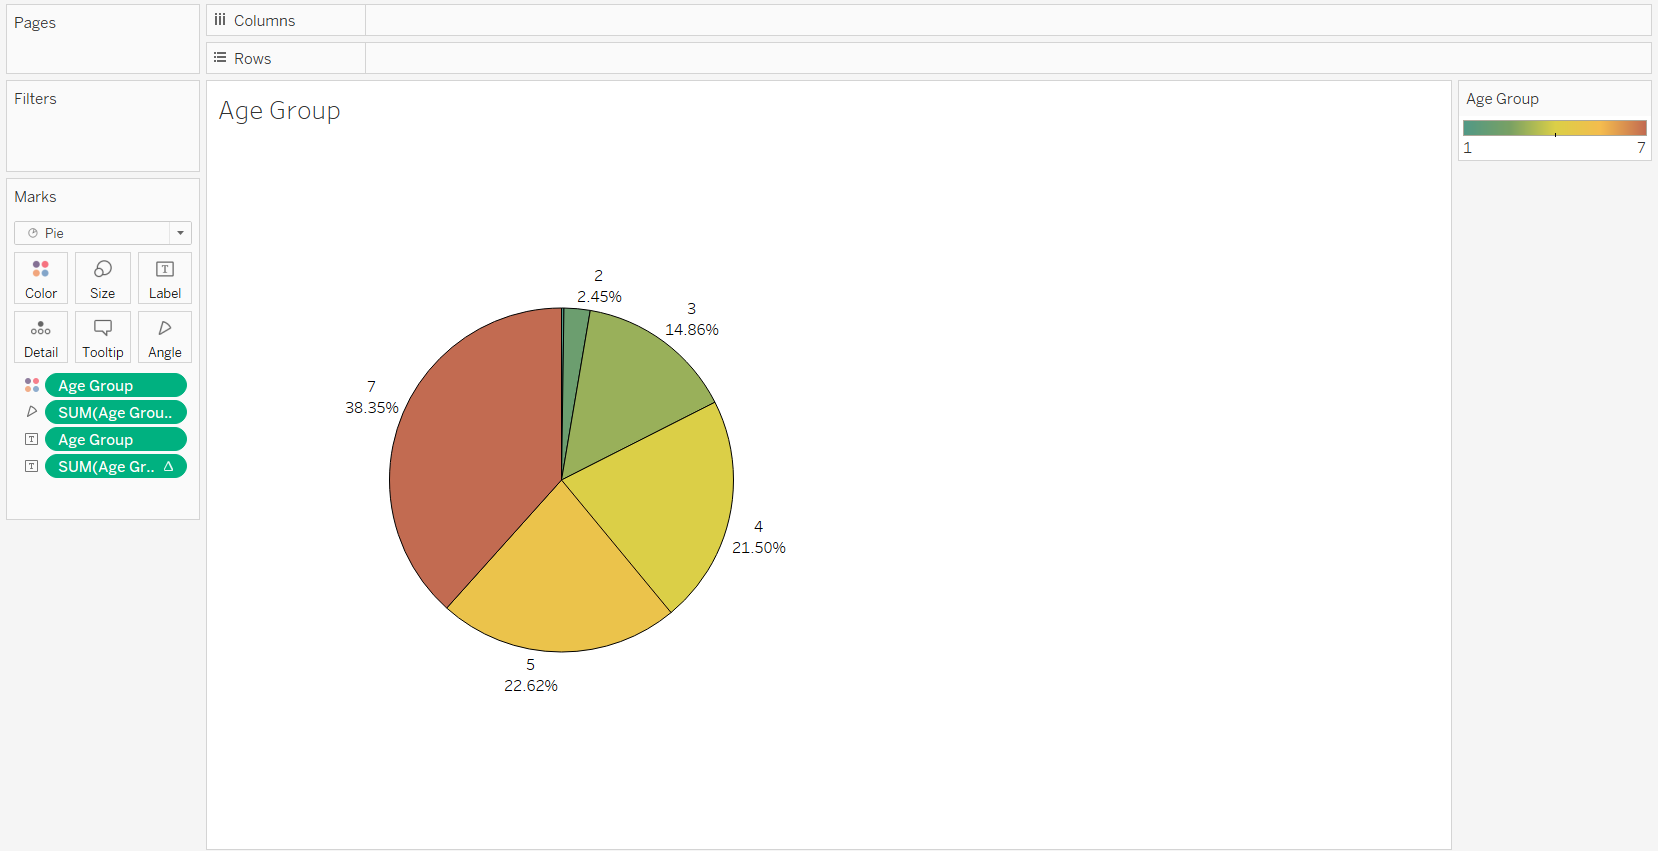

In [24]:
le = LabelEncoder()
originalDF.cat_input1 = le.fit_transform(originalDF.cat_input1) 
originalDF.cat_input2 = le.fit_transform(originalDF.cat_input2) 

cat_input1 and cat_input2 has text values. So we use LabelEncoder to encode it to numerical values.

In [25]:
originalDF

,b_tgt,int_tgt,cnt_tgt,cat_input1,cat_input2,demog_ho,demog_homeval,demog_inc,demog_pr,rfm1,...,rfm7,rfm8,rfm9,rfm10,rfm11,rfm12,demog_genf,demog_genm,account,age_group
1,1,7000.00,2.00,0,0,0,57587.00,52106.00,24,5.71,...,4,6,5,20,9,92,0,1,100000002.00,7
2,1,15000.00,2.00,0,0,0,44167.00,42422.00,0,12.80,...,3,8,16,27,11,91,0,1,100000003.00,7
3,0,0.00,0.00,0,0,0,90587.00,59785.00,32,21.60,...,2,7,15,19,9,123,1,0,100000004.00,4
4,0,0.00,0.00,0,0,0,100313.00,0.00,0,7.33,...,5,19,24,13,6,128,1,0,100000005.00,7
5,0,0.00,0.00,0,0,0,26622.00,34444.00,0,25.00,...,0,4,26,13,5,91,0,1,100000006.00,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1060033,0,0.00,0.00,2,4,1,44029.00,28584.00,28,15.00,...,1,1,23,8,3,23,1,0,101060034.00,5
1060034,0,0.00,0.00,2,4,1,49011.00,48129.00,24,15.00,...,1,1,23,8,3,23,1,0,101060035.00,4
1060035,0,0.00,0.00,2,4,0,49076.00,0.00,33,15.00,...,0,0,15,9,3,15,0,1,101060036.00,7
1060036,1,15000.00,1.00,1,4,0,46290.00,31205.00,34,6.00,...,2,2,16,13,6,21,0,1,101060037.00,4


In [28]:
originalDF.to_csv( r"O:\VIT\Winter Semester 2022-2023\Data Visualization\Project\bankdataset_half_preprocessed.csv")

# Exploratory Data Analysis

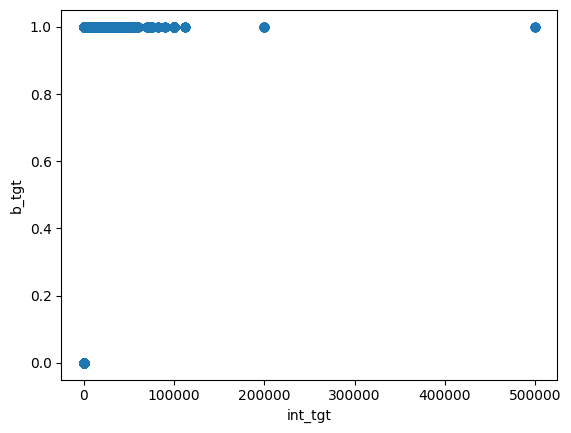

In [32]:
plt.scatter(originalDF['int_tgt'], originalDF['b_tgt'])
plt.xlabel("int_tgt")
plt.ylabel("b_tgt")
plt.show()

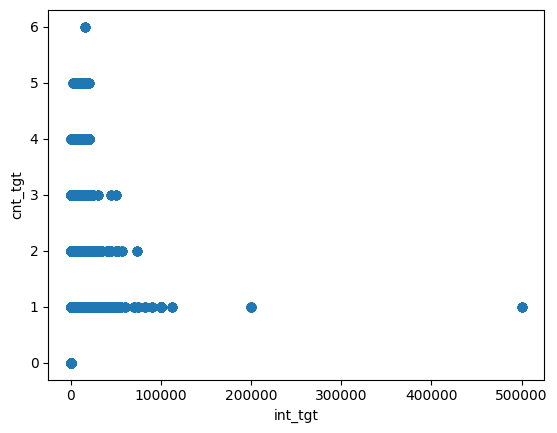

In [33]:
plt.scatter(originalDF['int_tgt'], originalDF['cnt_tgt'])
plt.xlabel("int_tgt")
plt.ylabel("cnt_tgt")
plt.show()

In [29]:
salesZeroDF = originalDF[(originalDF['b_tgt']==1) & (originalDF['cnt_tgt']>=1) & (originalDF['int_tgt']==0)]
salesZeroDF.shape

(3916, 25)

Finding the samples that has total sales (int_tgt) as 0 but they have bought a new product (b_tgt = 1) and count of new product (cnt_tgt) is greater than 1.

In [34]:
originalDF = pd.concat([originalDF, salesZeroDF]).drop_duplicates(keep=False)
originalDF.shape

(1056121, 25)

Removing the samples found in the previous code cell.

In [35]:
def expand_categories(values):
    result = []
    s = values.value_counts()
    t = float(len(values))
    for v in s.index:
        result.append("{}: {}%".format(v,round(100*(s[v]/t),2)))
    return "[{}]".format(", ".join(result))
        
def analyze(df):
    cols = df.columns.values
    total = float(len(df))
    for col in cols:
        uniques = df[col].unique()
        unique_count = len(uniques)
        if unique_count>100:
            print("--> {}:{} ({}%)".format(col,unique_count,int(((unique_count)/total)*100)))
        else:
            print("--> {}:{}".format(col,expand_categories(df[col])))
            expand_categories(df[col])

We are analyzing the data by looking at the unique values present in the dataset by calling analyze() function. We have displayed the percentage of the unique value in the column if the number of unique values is less than 100 to save display space. This is done by the expand_categories() function.

In [36]:
analyze(originalDF)

--> b_tgt:[0: 80.34%, 1: 19.66%]
--> int_tgt:[0.0: 80.34%, 10000.0: 1.71%, 15000.0: 1.32%, 5000.0: 1.2%, 20000.0: 0.96%, 12000.0: 0.94%, 11000.0: 0.92%, 7000.0: 0.91%, 8000.0: 0.89%, 6000.0: 0.88%, 9000.0: 0.87%, 14000.0: 0.87%, 16000.0: 0.87%, 19000.0: 0.86%, 13000.0: 0.83%, 3000.0: 0.83%, 17000.0: 0.83%, 4000.0: 0.82%, 18000.0: 0.81%, 1000.0: 0.79%, 2000.0: 0.76%, 25000.0: 0.35%, 21000.0: 0.09%, 30000.0: 0.07%, 50000.0: 0.05%, 40000.0: 0.03%, 22000.0: 0.02%, 35000.0: 0.02%, 100000.0: 0.02%, 26000.0: 0.02%, 12500.0: 0.01%, 24000.0: 0.01%, 23000.0: 0.01%, 27000.0: 0.01%, 36000.0: 0.01%, 31000.0: 0.01%, 45000.0: 0.01%, 7500.0: 0.01%, 33000.0: 0.0%, 28000.0: 0.0%, 37000.0: 0.0%, 2500.0: 0.0%, 52000.0: 0.0%, 38000.0: 0.0%, 200000.0: 0.0%, 70000.0: 0.0%, 51000.0: 0.0%, 39000.0: 0.0%, 34000.0: 0.0%, 32000.0: 0.0%, 60000.0: 0.0%, 29000.0: 0.0%, 75000.0: 0.0%, 42000.0: 0.0%, 320.0: 0.0%, 54000.0: 0.0%, 22500.0: 0.0%, 9370.0: 0.0%, 5450.0: 0.0%, 26500.0: 0.0%, 82000.0: 0.0%, 112000.0: 0.0%, 44

<Axes: >

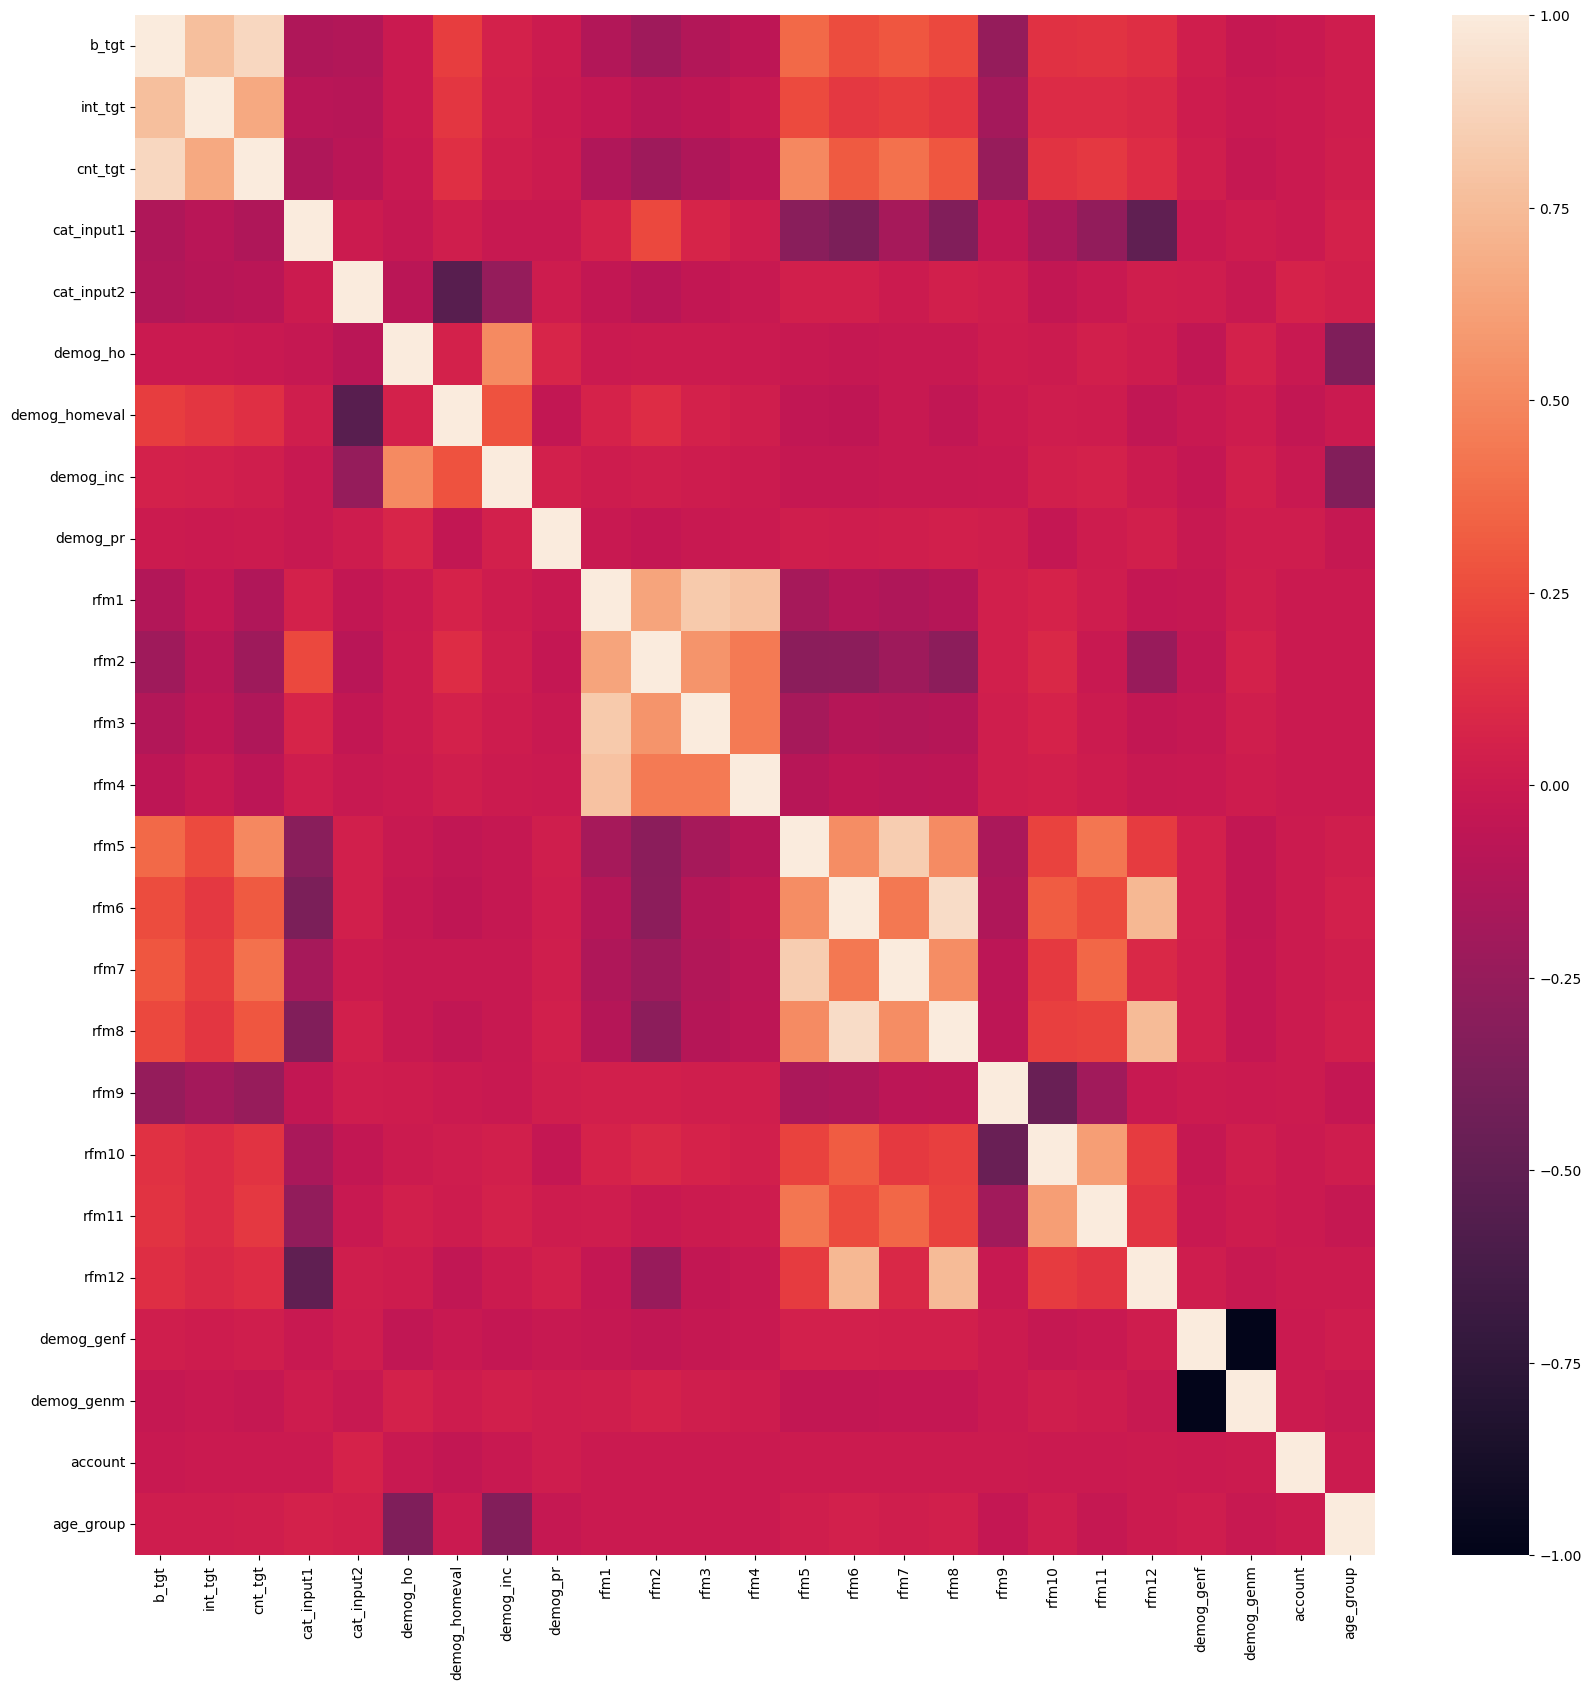

In [37]:
plt.subplots(figsize=(20,20))
sns.heatmap(originalDF.corr())

We can see that target variables are correlated but we cant remove them. Some of the variables have correlation but they are meaningful features so we cant remove these features also. Other variables have less correlation so we can ignore those features

In [38]:
originalDF.skew(axis=0)

b_tgt             1.53
int_tgt          10.57
cnt_tgt           2.43
cat_input1        1.66
cat_input2       -0.22
demog_ho         -0.20
demog_homeval     2.46
demog_inc         0.23
demog_pr         -0.15
rfm1            103.26
rfm2             11.13
rfm3            129.53
rfm4            206.88
rfm5              1.23
rfm6              1.91
rfm7              1.23
rfm8              1.42
rfm9             -0.60
rfm10             2.86
rfm11             0.32
rfm12             0.30
demog_genf       -0.25
demog_genm        0.25
account          -0.00
age_group         0.26
dtype: float64

We can see that the data is not normally distributed and it is skewed. So we take either square root or log tranformation based on which normalizes the data better.

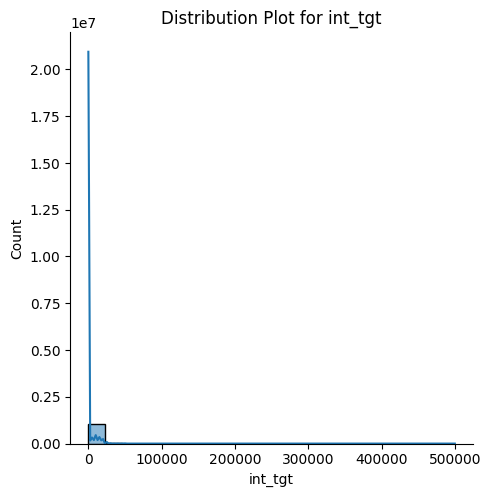

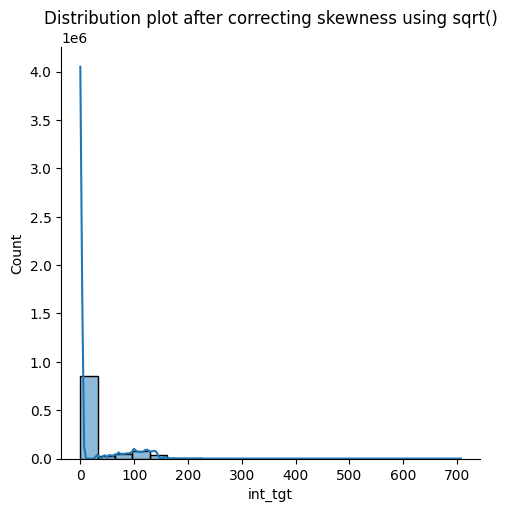

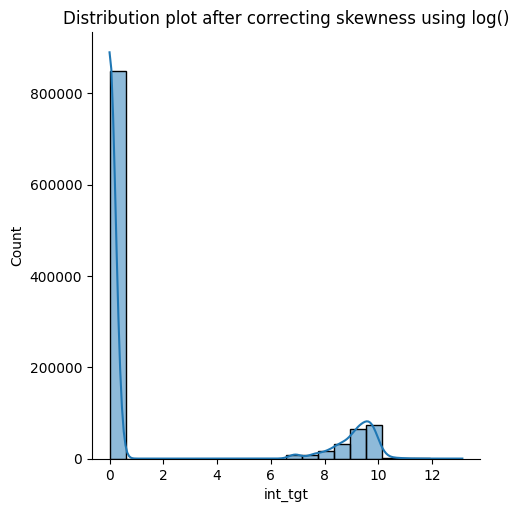

In [39]:
sns.displot(originalDF['int_tgt'], kde=True).set(title="Distribution Plot for int_tgt")
sns.displot(np.sqrt(originalDF['int_tgt']), kde=True).set(title="Distribution plot after correcting skewness using sqrt()")
sns.displot(np.log(originalDF['int_tgt']+1), kde=True).set(title="Distribution plot after correcting skewness using log()")
originalDF['int_tgt'] = np.sqrt(originalDF['int_tgt'])

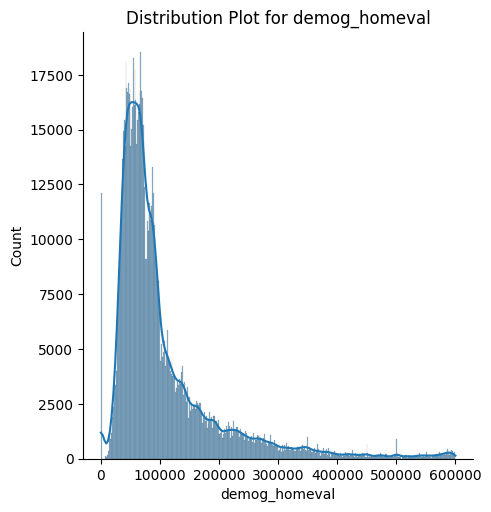

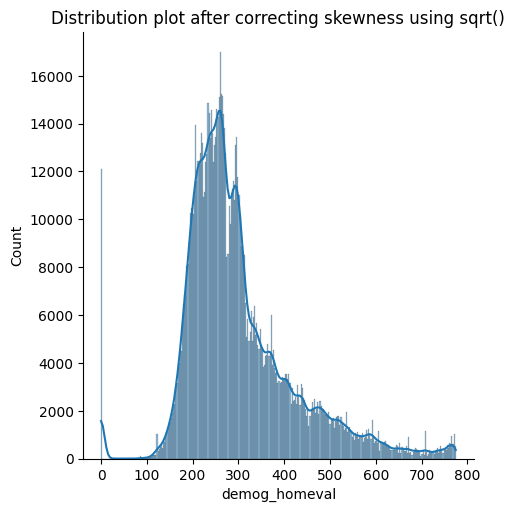

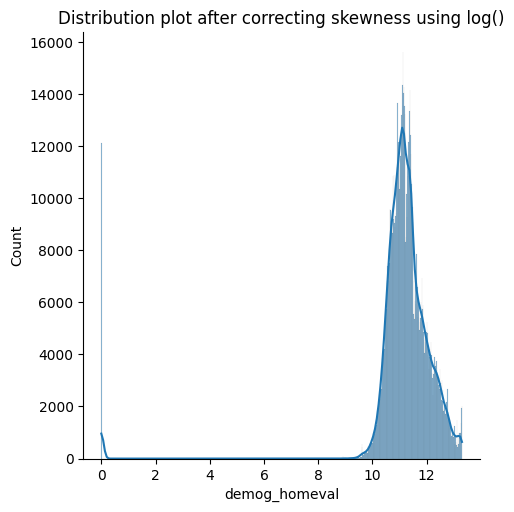

In [40]:
sns.displot(originalDF['demog_homeval'], kde=True).set(title="Distribution Plot for demog_homeval")
sns.displot(np.sqrt(originalDF['demog_homeval']), kde=True).set(title="Distribution plot after correcting skewness using sqrt()")
sns.displot(np.log(originalDF['demog_homeval']+1), kde=True).set(title="Distribution plot after correcting skewness using log()")
originalDF['demog_homeval'] = np.sqrt(originalDF['demog_homeval'])

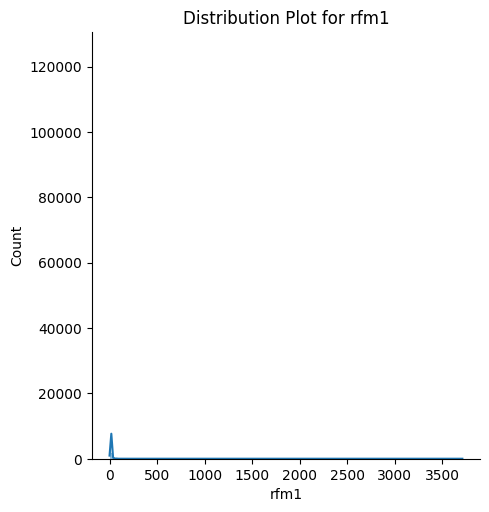

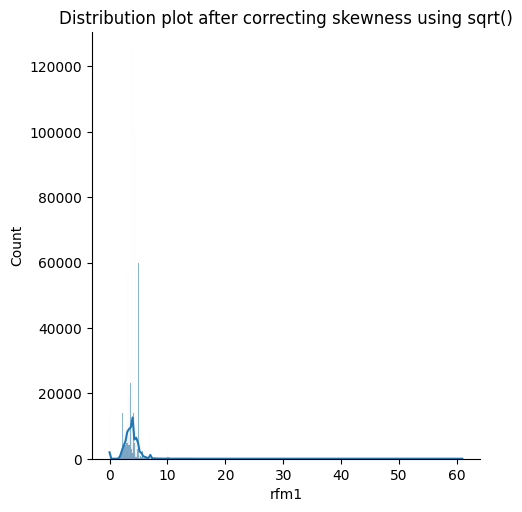

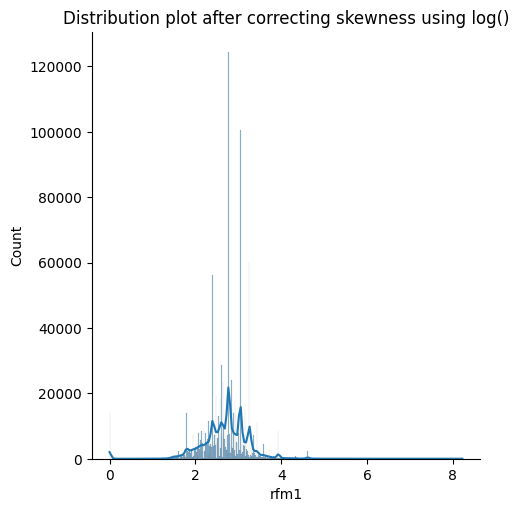

In [41]:
sns.displot(originalDF['rfm1'], kde=True).set(title="Distribution Plot for rfm1")
sns.displot(np.sqrt(originalDF['rfm1']), kde=True).set(title="Distribution plot after correcting skewness using sqrt()")
sns.displot(np.log(originalDF['rfm1']+1), kde=True).set(title="Distribution plot after correcting skewness using log()")
originalDF['rfm1'] = np.log(originalDF['rfm1']+1)

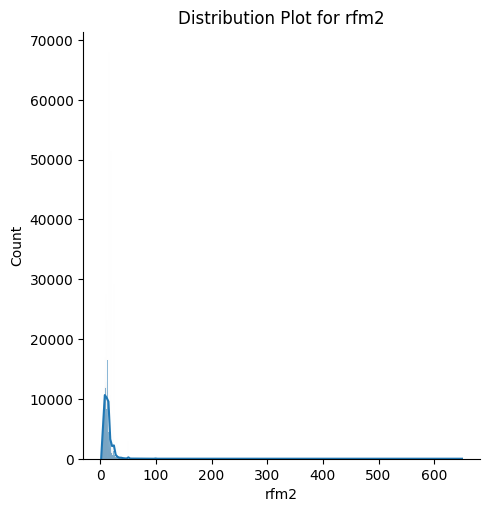

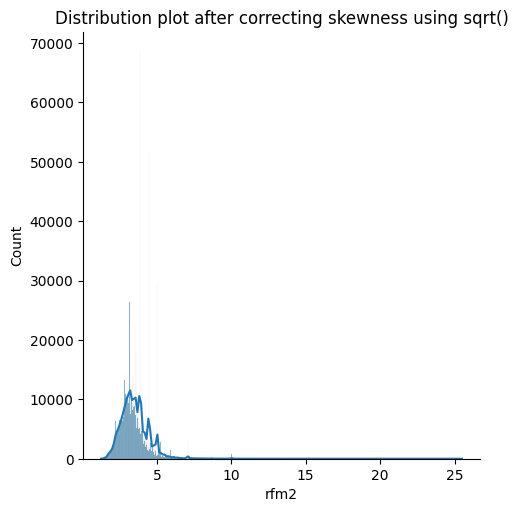

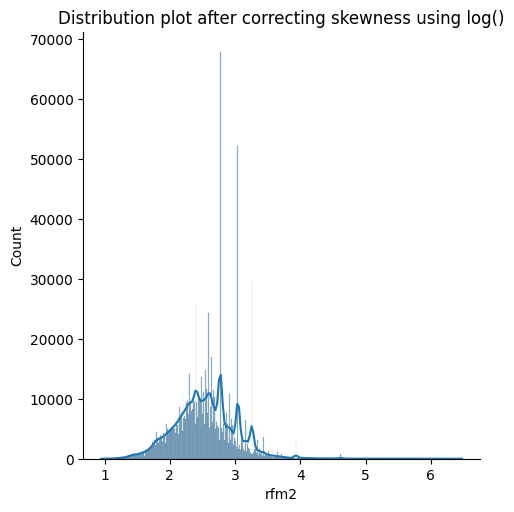

In [42]:
sns.displot(originalDF['rfm2'], kde=True).set(title="Distribution Plot for rfm2")
sns.displot(np.sqrt(originalDF['rfm2']), kde=True).set(title="Distribution plot after correcting skewness using sqrt()")
sns.displot(np.log(originalDF['rfm2']+1), kde=True).set(title="Distribution plot after correcting skewness using log()")
originalDF['rfm2'] = np.log(originalDF['rfm2']+1)

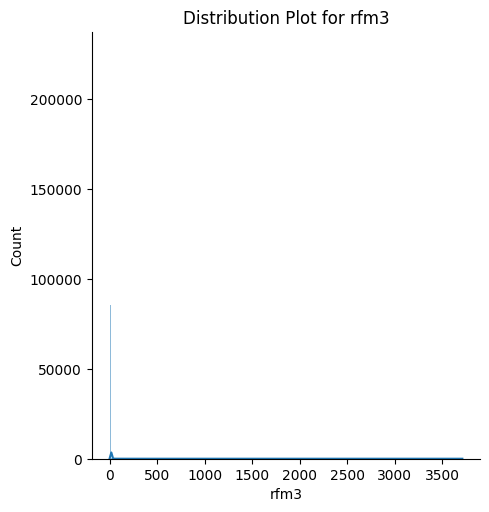

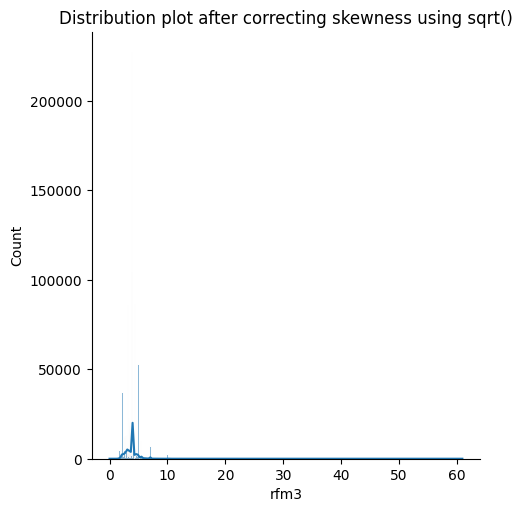

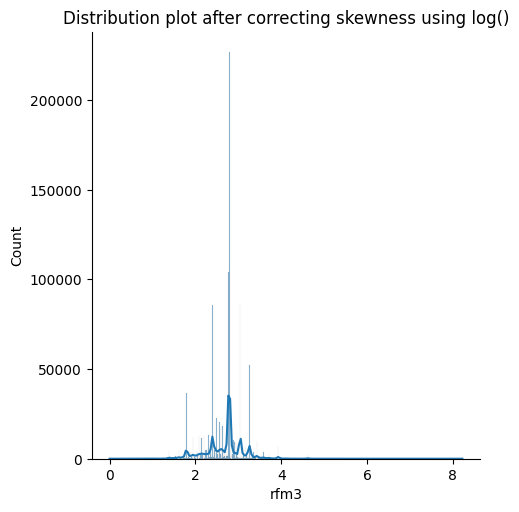

In [43]:
sns.displot(originalDF['rfm3'], kde=True).set(title="Distribution Plot for rfm3")
sns.displot(np.sqrt(originalDF['rfm3']), kde=True).set(title="Distribution plot after correcting skewness using sqrt()")
sns.displot(np.log(originalDF['rfm3']+1), kde=True).set(title="Distribution plot after correcting skewness using log()")
originalDF['rfm3'] = np.log(originalDF['rfm3']+1)

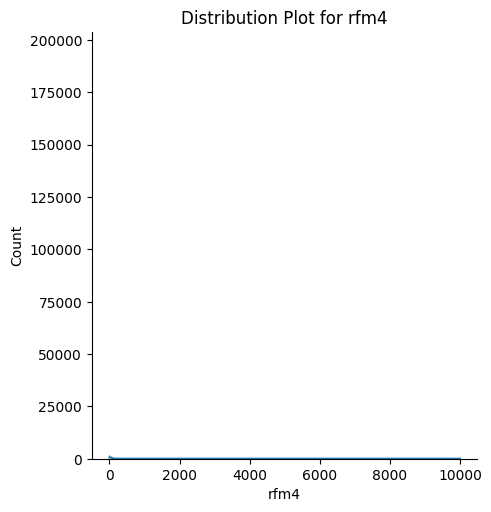

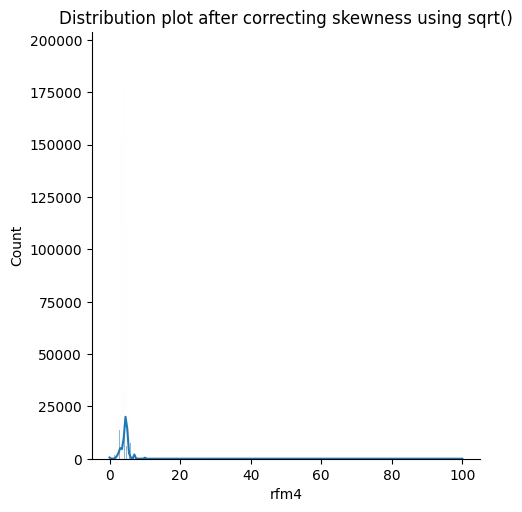

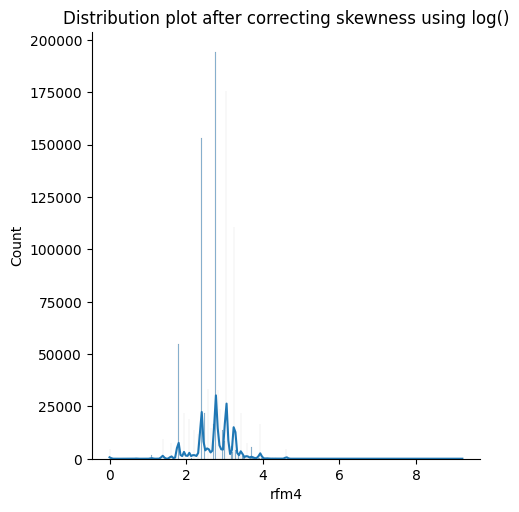

In [44]:
sns.displot(originalDF['rfm4'], kde=True).set(title="Distribution Plot for rfm4")
sns.displot(np.sqrt(originalDF['rfm4']), kde=True).set(title="Distribution plot after correcting skewness using sqrt()")
sns.displot(np.log(originalDF['rfm4']+1), kde=True).set(title="Distribution plot after correcting skewness using log()")
originalDF['rfm4'] = np.log(originalDF['rfm4']+1)

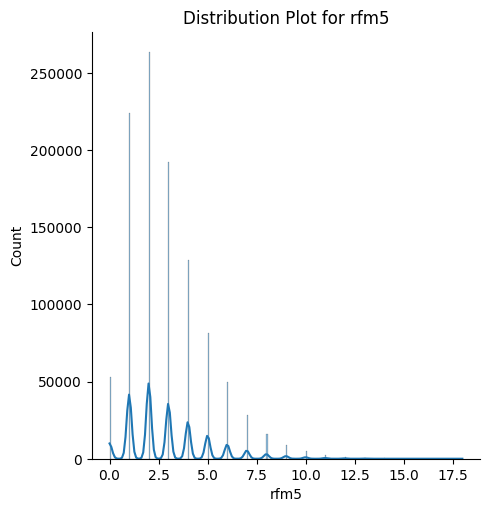

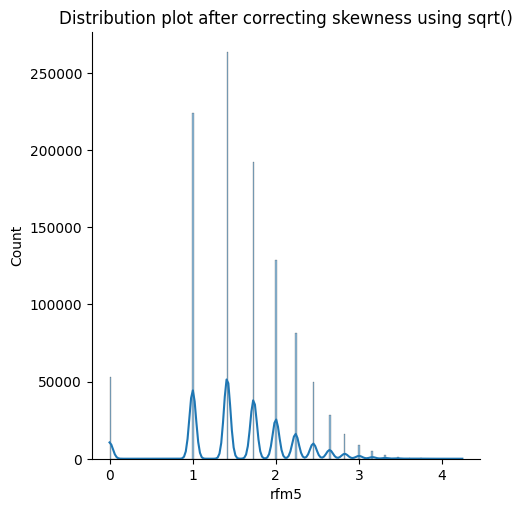

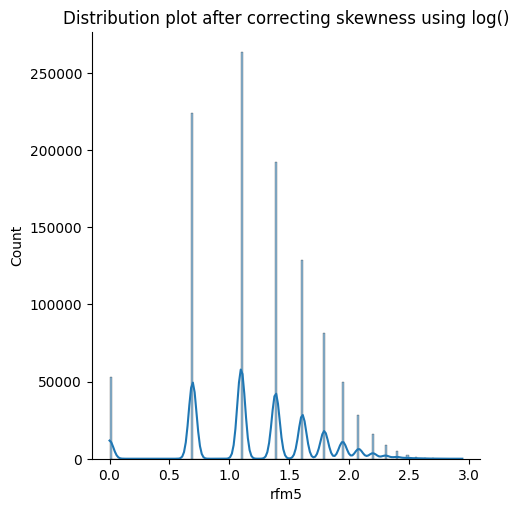

In [45]:
sns.displot(originalDF['rfm5'], kde=True).set(title="Distribution Plot for rfm5")
sns.displot(np.sqrt(originalDF['rfm5']), kde=True).set(title="Distribution plot after correcting skewness using sqrt()")
sns.displot(np.log(originalDF['rfm5']+1), kde=True).set(title="Distribution plot after correcting skewness using log()")
originalDF['rfm5'] = np.log(originalDF['rfm5']+1)

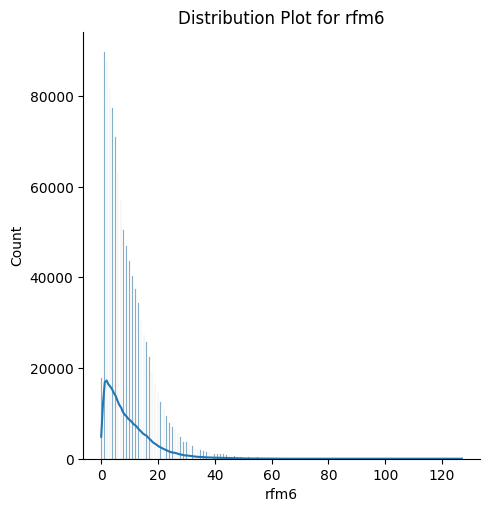

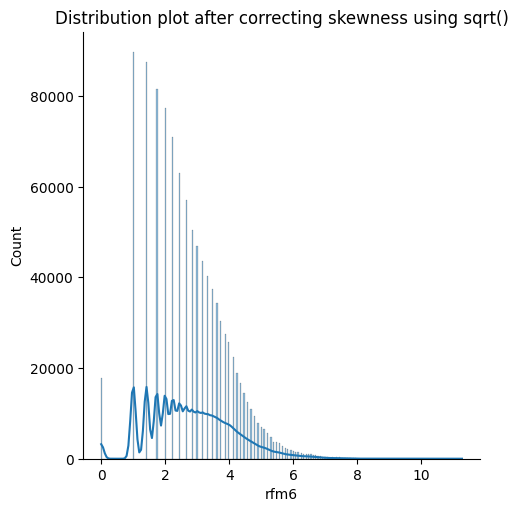

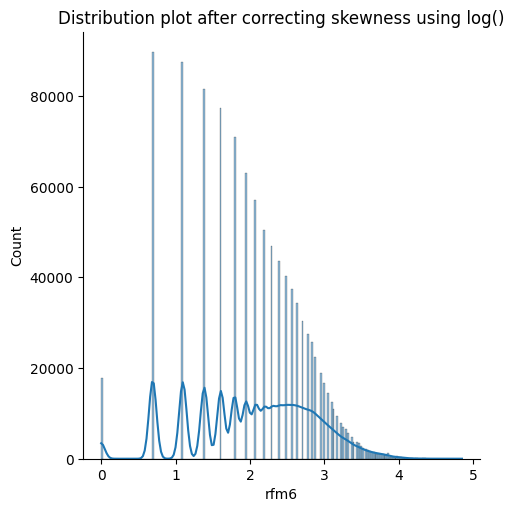

In [46]:
sns.displot(originalDF['rfm6'], kde=True).set(title="Distribution Plot for rfm6")
sns.displot(np.sqrt(originalDF['rfm6']), kde=True).set(title="Distribution plot after correcting skewness using sqrt()")
sns.displot(np.log(originalDF['rfm6']+1), kde=True).set(title="Distribution plot after correcting skewness using log()")
originalDF['rfm6'] = np.log(originalDF['rfm6']+1)

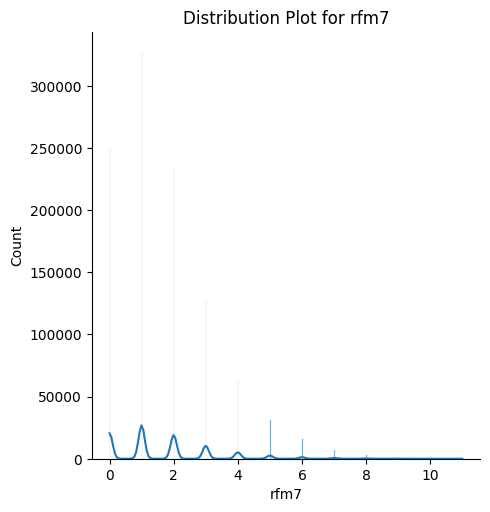

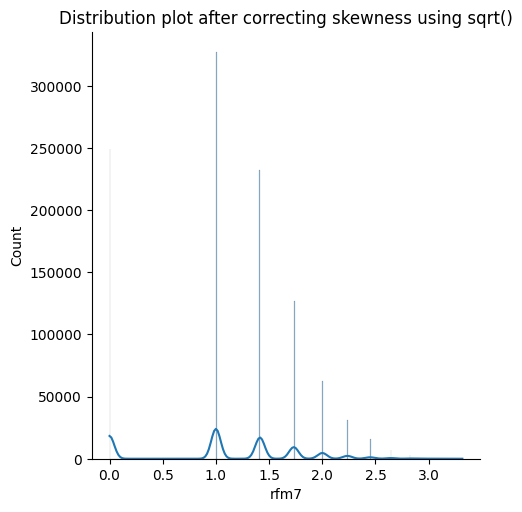

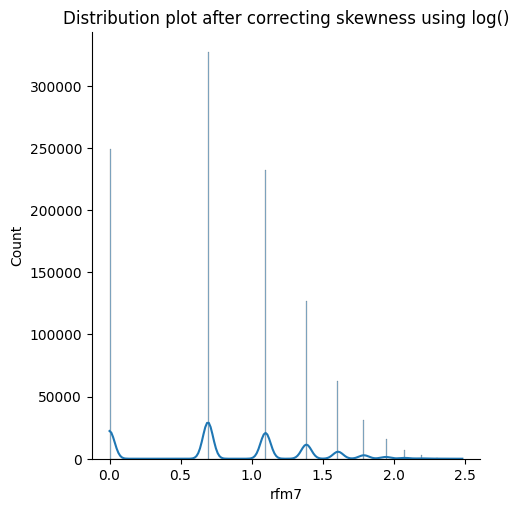

In [47]:
sns.displot(originalDF['rfm7'], kde=True).set(title="Distribution Plot for rfm7")
sns.displot(np.sqrt(originalDF['rfm7']), kde=True).set(title="Distribution plot after correcting skewness using sqrt()")
sns.displot(np.log(originalDF['rfm7']+1), kde=True).set(title="Distribution plot after correcting skewness using log()")
originalDF['rfm7'] = np.log(originalDF['rfm7']+1)

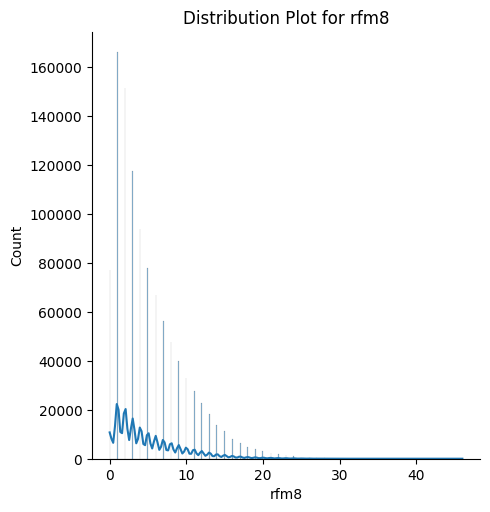

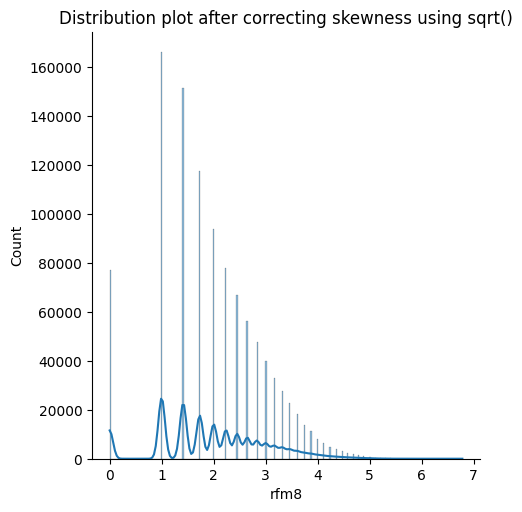

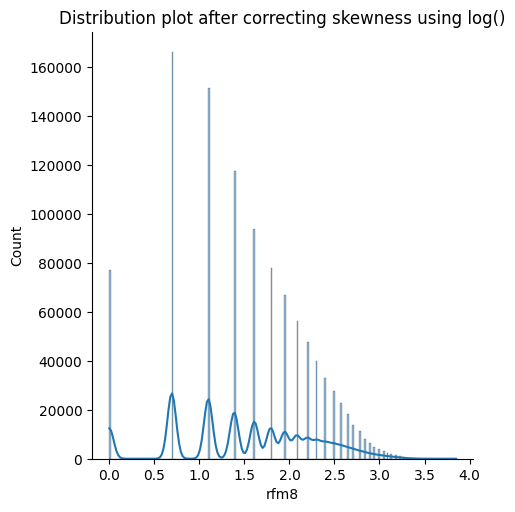

In [48]:
sns.displot(originalDF['rfm8'], kde=True).set(title="Distribution Plot for rfm8")
sns.displot(np.sqrt(originalDF['rfm8']), kde=True).set(title="Distribution plot after correcting skewness using sqrt()")
sns.displot(np.log(originalDF['rfm8']+1), kde=True).set(title="Distribution plot after correcting skewness using log()")
originalDF['rfm8'] = np.log(originalDF['rfm8']+1)

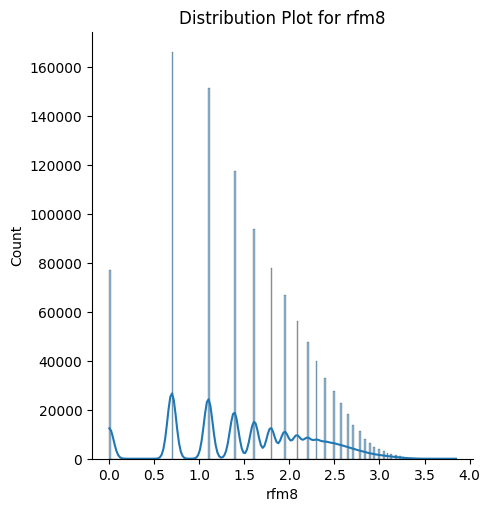

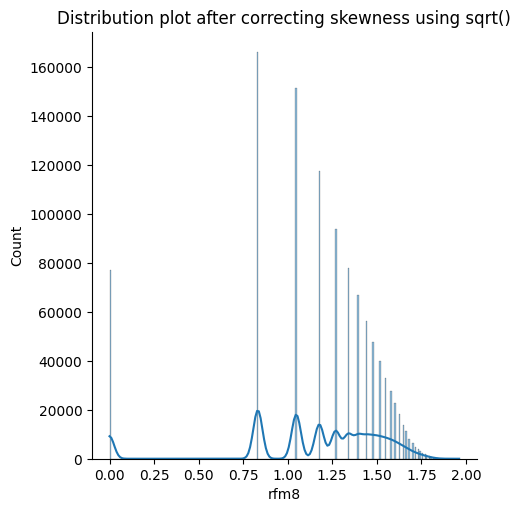

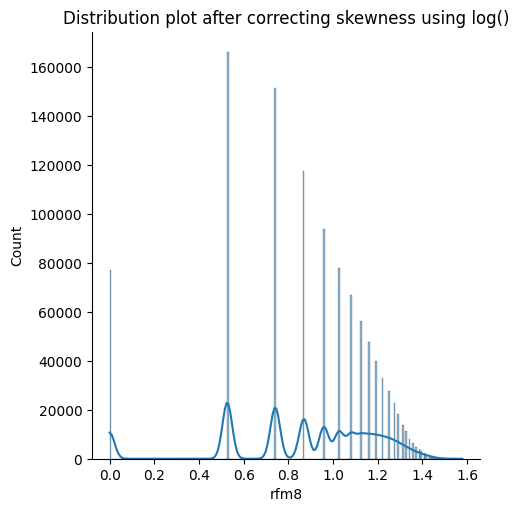

In [49]:
sns.displot(originalDF['rfm8'], kde=True).set(title="Distribution Plot for rfm8")
sns.displot(np.sqrt(originalDF['rfm8']), kde=True).set(title="Distribution plot after correcting skewness using sqrt()")
sns.displot(np.log(originalDF['rfm8']+1), kde=True).set(title="Distribution plot after correcting skewness using log()")
originalDF['rfm8'] = np.log(originalDF['rfm8']+1)

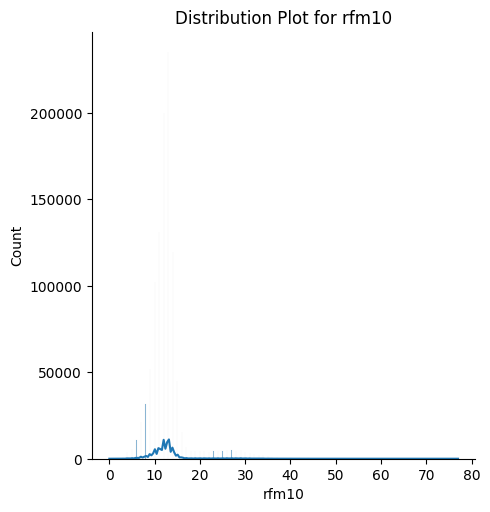

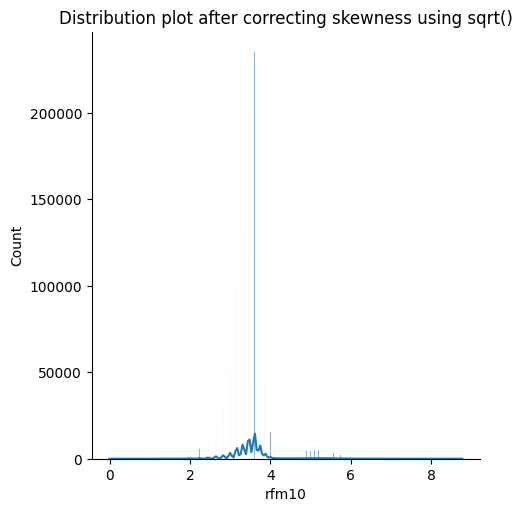

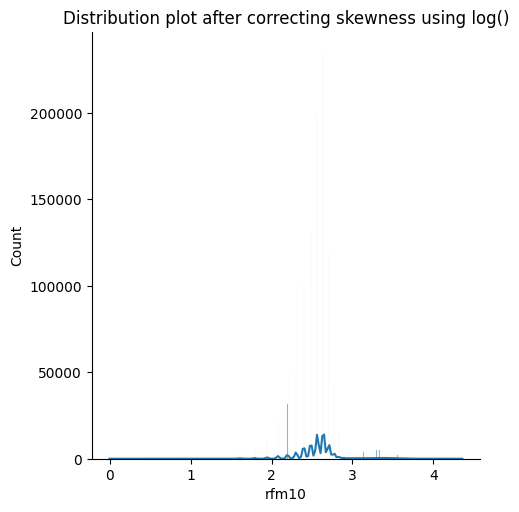

In [50]:
sns.displot(originalDF['rfm10'], kde=True).set(title="Distribution Plot for rfm10")
sns.displot(np.sqrt(originalDF['rfm10']), kde=True).set(title="Distribution plot after correcting skewness using sqrt()")
sns.displot(np.log(originalDF['rfm10']+1), kde=True).set(title="Distribution plot after correcting skewness using log()")
originalDF['rfm10'] = np.log(originalDF['rfm10']+1)

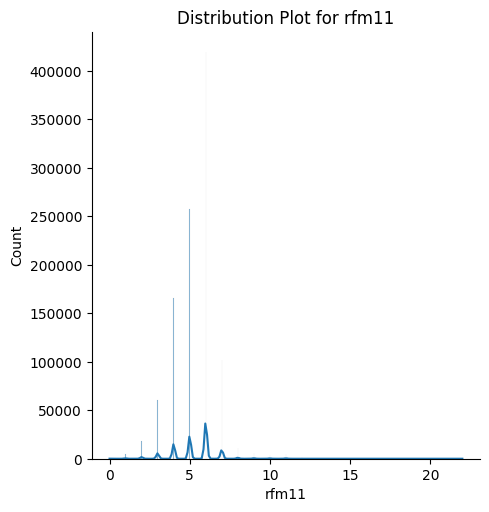

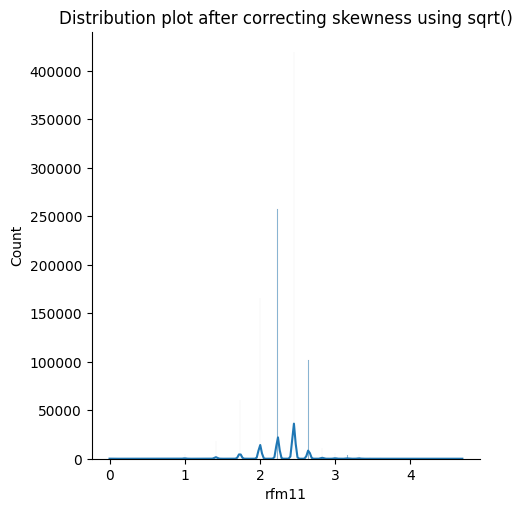

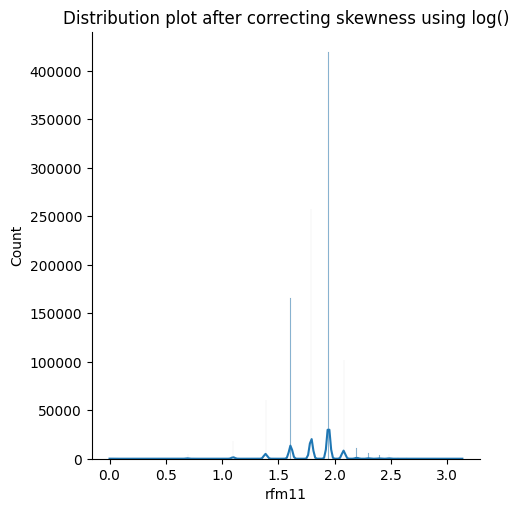

In [51]:
sns.displot(originalDF['rfm11'], kde=True).set(title="Distribution Plot for rfm11")
sns.displot(np.sqrt(originalDF['rfm11']), kde=True).set(title="Distribution plot after correcting skewness using sqrt()")
sns.displot(np.log(originalDF['rfm11']+1), kde=True).set(title="Distribution plot after correcting skewness using log()")
originalDF['rfm11'] = np.log(originalDF['rfm11']+1)

In [52]:
originalDF.skew(axis=0)

b_tgt            1.53
int_tgt          2.01
cnt_tgt          2.43
cat_input1       1.66
cat_input2      -0.22
demog_ho        -0.20
demog_homeval    1.23
demog_inc        0.23
demog_pr        -0.15
rfm1            -1.12
rfm2             0.36
rfm3             0.01
rfm4            -0.46
rfm5            -0.22
rfm6            -0.21
rfm7            -0.03
rfm8            -0.92
rfm9            -0.60
rfm10            0.72
rfm11           -1.35
rfm12            0.30
demog_genf      -0.25
demog_genm       0.25
account         -0.00
age_group        0.26
dtype: float64

We can see that the skewness have been reduced significantly and the data has been normalized properly.

In [53]:
analyze(originalDF)

--> b_tgt:[0: 80.34%, 1: 19.66%]
--> int_tgt:[0.0: 80.34%, 100.0: 1.71%, 122.47448713915891: 1.32%, 70.71067811865476: 1.2%, 141.4213562373095: 0.96%, 109.54451150103323: 0.94%, 104.88088481701516: 0.92%, 83.66600265340756: 0.91%, 89.44271909999159: 0.89%, 77.45966692414834: 0.88%, 94.86832980505137: 0.87%, 118.32159566199232: 0.87%, 126.49110640673517: 0.87%, 137.84048752090223: 0.86%, 114.0175425099138: 0.83%, 54.772255750516614: 0.83%, 130.38404810405297: 0.83%, 63.245553203367585: 0.82%, 134.16407864998737: 0.81%, 31.622776601683793: 0.79%, 44.721359549995796: 0.76%, 158.11388300841898: 0.35%, 144.9137674618944: 0.09%, 173.20508075688772: 0.07%, 223.60679774997897: 0.05%, 200.0: 0.03%, 148.32396974191326: 0.02%, 187.08286933869707: 0.02%, 316.22776601683796: 0.02%, 161.24515496597098: 0.02%, 111.80339887498948: 0.01%, 154.91933384829667: 0.01%, 151.65750888103102: 0.01%, 164.31676725154983: 0.01%, 189.73665961010275: 0.01%, 176.0681686165901: 0.01%, 212.13203435596427: 0.01%, 86.60

## Outlier Detection and Removal

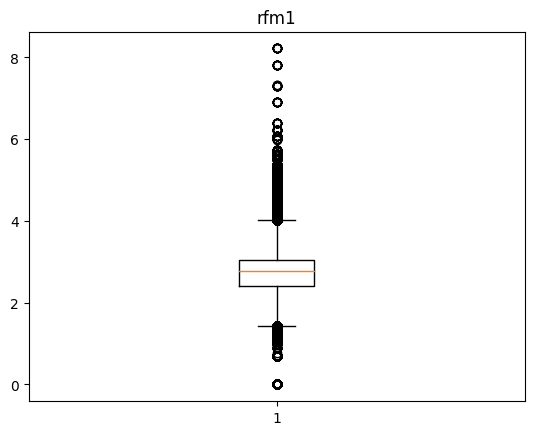

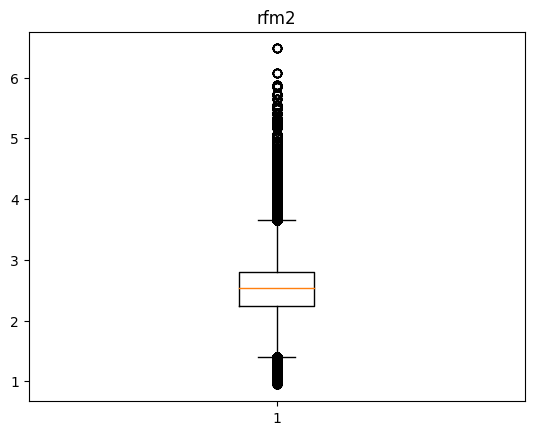

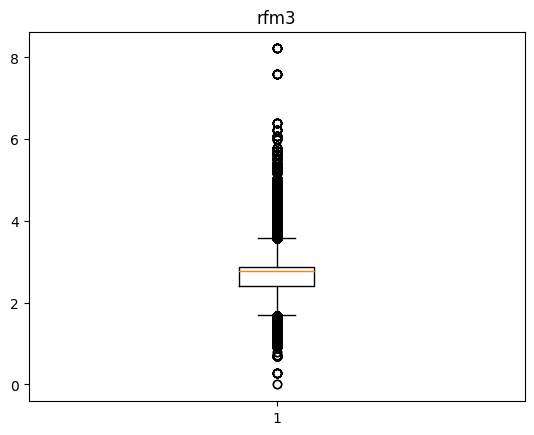

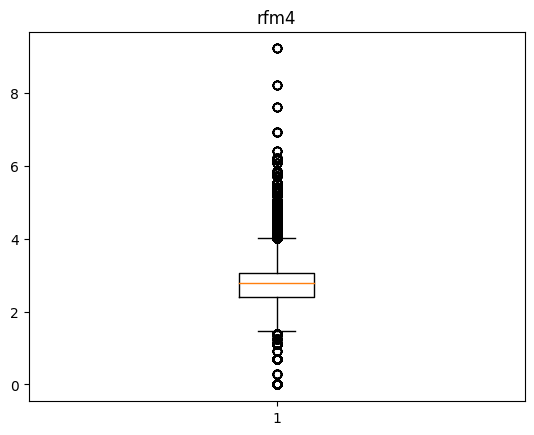

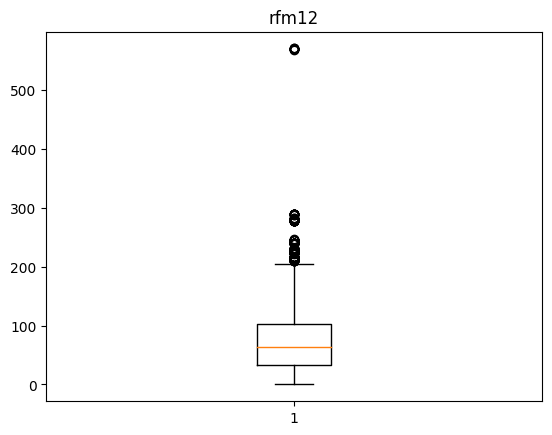

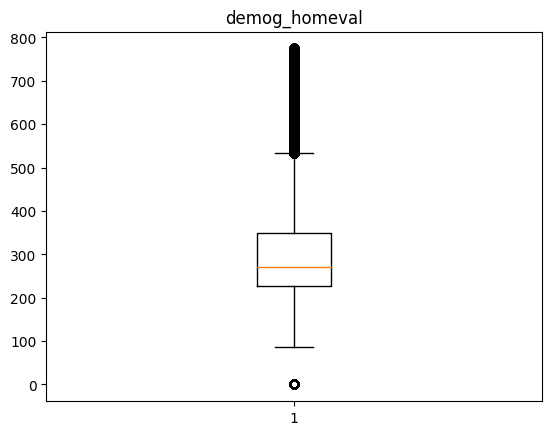

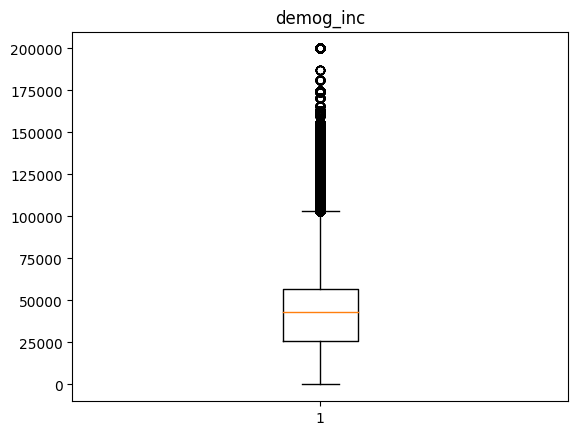

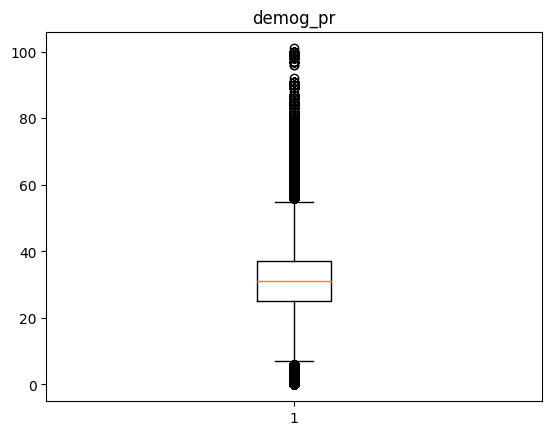

In [54]:
numericalCols = ['rfm1', 'rfm2', 'rfm3', 'rfm4', 'rfm12', 'demog_homeval', 'demog_inc', 'demog_pr']
for col in numericalCols:
    plt.boxplot(originalDF[col])
    plt.title(col)
    plt.show()

Using Inter Quartile Range of 10% and 90% to remove outliers.

In [55]:
Q1 = originalDF.rfm12.quantile(0.1)
Q3 = originalDF.rfm12.quantile(0.9)
IQR = Q3 - Q1
lower_limit = Q1 - 1.5*IQR
upper_limit = Q3 + 1.5*IQR
originalDF[(originalDF.rfm12<lower_limit)|(originalDF.rfm12>upper_limit)]

,b_tgt,int_tgt,cnt_tgt,cat_input1,cat_input2,demog_ho,demog_homeval,demog_inc,demog_pr,rfm1,...,rfm7,rfm8,rfm9,rfm10,rfm11,rfm12,demog_genf,demog_genm,account,age_group
322,0,0.00,0.00,0,0,0,258.84,0.00,0,3.65,...,0.69,1.16,10,3.50,2.20,289,1,0,100000323.00,5
51377,1,94.87,1.00,0,4,0,151.99,0.00,26,2.56,...,1.61,1.41,5,3.37,2.30,571,1,0,100051378.00,5
61721,0,0.00,0.00,0,4,0,228.63,0.00,39,2.34,...,0.69,1.22,15,3.18,2.20,282,1,0,100061722.00,5
96689,0,0.00,0.00,0,0,0,258.79,0.00,0,3.62,...,0.69,1.16,10,3.50,2.20,289,1,0,100096690.00,5
147744,1,94.87,1.00,0,4,0,151.96,0.00,25,2.56,...,1.39,1.40,4,3.33,2.20,570,1,0,100147745.00,5
158088,0,0.00,0.00,1,4,0,228.70,0.00,39,2.34,...,0.69,1.22,15,3.18,2.20,282,1,0,100158089.00,5
193056,0,0.00,0.00,0,0,0,258.80,0.00,0,3.65,...,0.00,1.12,9,3.47,2.08,288,1,0,100193057.00,5
244111,1,94.87,1.00,0,4,0,151.90,0.00,25,2.56,...,1.39,1.40,4,3.33,2.20,570,1,0,100244112.00,5
254455,0,0.00,0.00,0,4,0,228.70,0.00,39,2.34,...,0.69,1.22,15,3.18,2.20,282,1,0,100254456.00,5
289423,0,0.00,0.00,0,0,0,258.82,0.00,0,3.65,...,0.69,1.16,10,3.50,2.20,289,1,0,100289424.00,5


In [56]:
originalDF = originalDF[(originalDF.rfm12>lower_limit)&(originalDF.rfm12<upper_limit)]

We are removing only the 32 outlier present in rfm12 column and not other coulm because they all are useful samples which willincrease the scope of the model unlike the outliers present in rfm12 which can be visualized through box plot.

In [57]:
df = originalDF

In [58]:
df.drop(['account'], axis=1, inplace=True)
df

,b_tgt,int_tgt,cnt_tgt,cat_input1,cat_input2,demog_ho,demog_homeval,demog_inc,demog_pr,rfm1,...,rfm6,rfm7,rfm8,rfm9,rfm10,rfm11,rfm12,demog_genf,demog_genm,age_group
1,1,83.67,2.00,0,0,0,239.97,52106.00,24,1.90,...,3.14,1.61,1.08,5,3.04,2.30,92,0,1,7
2,1,122.47,2.00,0,0,0,210.16,42422.00,0,2.62,...,2.83,1.39,1.16,16,3.33,2.48,91,0,1,7
3,0,0.00,0.00,0,0,0,300.98,59785.00,32,3.12,...,3.09,1.10,1.12,15,3.00,2.30,123,1,0,4
4,0,0.00,0.00,0,0,0,316.72,0.00,0,2.12,...,3.66,1.79,1.39,24,2.64,1.95,128,1,0,7
5,0,0.00,0.00,0,0,0,163.16,34444.00,0,3.26,...,2.64,0.00,0.96,26,2.64,1.79,91,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1060033,0,0.00,0.00,2,4,1,209.83,28584.00,28,2.77,...,0.69,0.69,0.53,23,2.20,1.39,23,1,0,5
1060034,0,0.00,0.00,2,4,1,221.38,48129.00,24,2.77,...,0.69,0.69,0.53,23,2.20,1.39,23,1,0,4
1060035,0,0.00,0.00,2,4,0,221.53,0.00,33,2.77,...,0.00,0.00,0.00,15,2.30,1.39,15,0,1,7
1060036,1,122.47,1.00,1,4,0,215.15,31205.00,34,1.95,...,1.39,1.10,0.74,16,2.64,1.95,21,0,1,4


In [59]:
df.to_csv(r"O:\VIT\Winter Semester 2022-2023\Data Visualization\Project\bankdataset_fully_preprocessed.csv")

## Data Selection

In [35]:
X = df.drop(['b_tgt', 'int_tgt', 'cnt_tgt'], axis=1, inplace=False)
y = df[['b_tgt', 'int_tgt', 'cnt_tgt']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
y1_train = y_train['b_tgt']
y1_test = y_test['b_tgt']
y2_train = y_train['int_tgt']
y2_test = y_test['int_tgt']
y3_train = y_train['cnt_tgt']
y3_test = y_test['cnt_tgt']

Splitting into 80%  train data and 20% test data.

## Predicting b_tgt variable using classification algorithms

In [54]:
model_params = {
    'Logistic Regression' : {
        'model': LogisticRegression(),
        'params': {
            'C': [0.1, 2, 4, 6, 8, 10],
            'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
            'multi_class': ['auto', 'ovr', 'multinomial']
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [10, 50, 100, 200, 300, 400, 500],
            'criterion': ['gini', 'entropy', 'log_loss'],
            'max_features': ['None', 'sqrt', 'log2']
        }
    },
    'Decision Tree' : {
        'model': tree.DecisionTreeClassifier(),
        'params': {
            'criterion': ['gini', 'entropy', 'log_loss'],
            'splitter': ['best', 'random'],
            'max_features': ['auto', 'sqrt', 'log2']
        }
    }
}

In [59]:
scores1 = []

for model_name, mp in model_params.items():
    clf =  RandomizedSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y1_train)
    print(model_name)
    scores1.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_,
        'accuracy' : clf.score(X_test, y1_test)
    })

acc1 = pd.DataFrame(scores1,columns=['model','best_score','best_params', 'accuracy'])
acc1

Logistic Regression
Random Forest
Decision Tree


,model,best_score,best_params,accuracy
0,Logistic Regression,0.85,"{'solver': 'newton-cg', 'multi_class': 'ovr', ...",0.85
1,Random Forest,0.99,"{'n_estimators': 300, 'max_features': 'log2', ...",0.99
2,Decision Tree,0.98,"{'splitter': 'best', 'max_features': 'auto', '...",0.98


In [60]:
maxAccuracy = acc1['accuracy'].max()
bestModel = acc1.loc[acc1['accuracy'] == maxAccuracy]
modelSelect = model_params[bestModel['model'].iloc[0]]
bestModelParameters = bestModel['best_params'].iloc[0]
bestModel

,model,best_score,best_params,accuracy
1,Random Forest,0.99,"{'n_estimators': 300, 'max_features': 'log2', ...",0.99


In [61]:
model = modelSelect['model']
model.set_params(**bestModelParameters)

RandomForestClassifier(max_features='log2', n_estimators=300)

In [68]:
mod = model.fit(X_train, y1_train)

In [69]:
with open('name.pkl', 'wb') as f3:
    pickle.dump(mod, f3)

In [41]:
with open('name.pkl', 'rb') as f2:
        model1_1 = pickle.load(f2)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00    169497
           1       0.99      0.97      0.98     41721

    accuracy                           0.99    211218
   macro avg       0.99      0.98      0.99    211218
weighted avg       0.99      0.99      0.99    211218



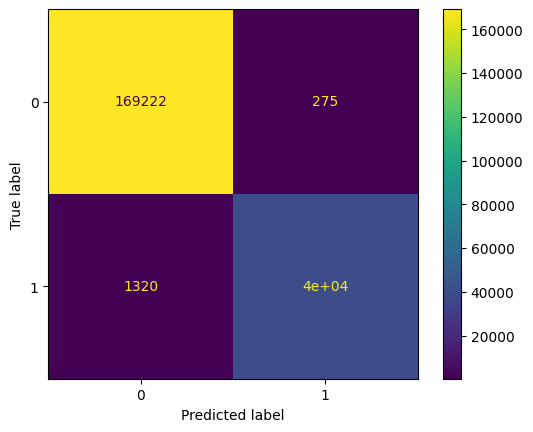

In [42]:
y1_predict = model1_1.predict(X_test)
print(classification_report(y1_test, y1_predict))
confusionMatrix = metrics.confusion_matrix(y1_test, y1_predict)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusionMatrix)
cm_display.plot()
plt.show()

In [78]:
from sklearn.metrics import accuracy_score
accuracy_score(y1_test,y1_predict)

0.9924485602552813

## Predicting int_tgt variable using prediction algorithm

In [36]:
# Predicting using Multi-Variate Regression
model2_1 = LinearRegression()
model2_1.fit(X_train, y2_train)
y2_predict = model2_1.predict(X_test)
mse = metrics.mean_squared_error(y2_test, y2_predict)  
rmse = np.sqrt(mse)
print("Root Mean Square Error: "+str(rmse))

Root Mean Square Error: 38.44078838291896


## Predicting cnt_tgt variable using prediction algorithms

In [37]:
# Predicting using Poisson Regression
model3_1 = linear_model.PoissonRegressor()
model3_1.fit(X_train, y3_train)
y3_predict = model3_1.predict(X_test)
mse = metrics.mean_squared_error(y3_test, y3_predict)  
rmse = np.sqrt(mse)
print("Root Mean Square Error: "+str(rmse))

Root Mean Square Error: 0.6959821215646822


In [38]:
# Predicting using Multi-Variate Regression
model3_2 = LinearRegression()
model3_2.fit(X_train, y3_train)
y3_predict = model3_2.predict(X_test)
mse = metrics.mean_squared_error(y3_test, y3_predict)  
rmse = np.sqrt(mse)
print("Root Mean Square Error: "+str(rmse))

Root Mean Square Error: 0.5810499742307964


In [6]:
filePath = r"O:\VIT\Winter Semester 2022-2023\Data Visualization\Project\bankdataset_fully_preprocessed.csv"
df = pd.read_csv(filePath)
X = df.drop(['b_tgt', 'int_tgt', 'cnt_tgt'], axis=1, inplace=False)
y = df[['b_tgt', 'int_tgt', 'cnt_tgt']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
y1_train = y_train['b_tgt']
y1_test = y_test['b_tgt']
y2_train = y_train['int_tgt']
y2_test = y_test['int_tgt']
y3_train = y_train['cnt_tgt']
y3_test = y_test['cnt_tgt']

## Feature Selection

In [9]:
model = RandomForestRegressor(n_estimators=300,max_features='log2')
model.fit(X_train, y2_train)
importance = model.feature_importances_

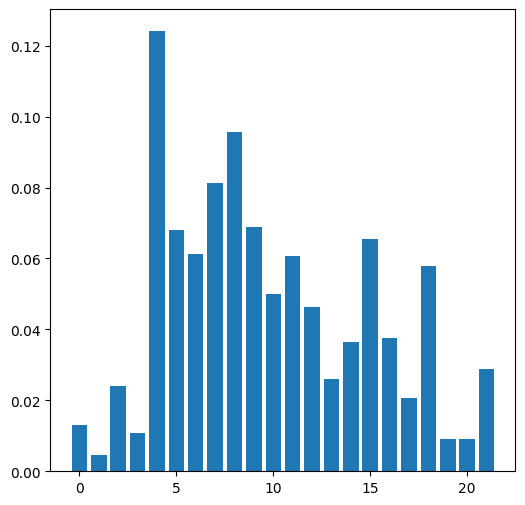

In [10]:
plt.figure(figsize=(6,6))
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [11]:
q1=np.quantile(importance, .25)
q1

0.021637328140448088

In [12]:
loc=[]
for i,v in enumerate(importance):
    if(v<q1):
        print('Feature: %0d, Score: %.5f' % (i,v))
        loc.append(i)

Feature: 0, Score: 0.01313
Feature: 1, Score: 0.00455
Feature: 3, Score: 0.01086
Feature: 17, Score: 0.02079
Feature: 19, Score: 0.00908
Feature: 20, Score: 0.00909


In [15]:
X_train = X_train.drop(X_train.columns[[0, 1, 3, 17, 19, 20]],axis = 1)

In [18]:
X_test = X_test.drop(X_test.columns[[0, 1, 3, 17, 19, 20]],axis = 1)

## Predicting int_tgt variable using prediction algorithm after feature selection

In [19]:
# Predicting using Multi-Variate Regression
model2_1 = LinearRegression()
model2_1.fit(X_train, y2_train)
y2_predict = model2_1.predict(X_test)
mse = metrics.mean_squared_error(y2_test, y2_predict)  
rmse = np.sqrt(mse)
print("Root Mean Square Error: "+str(rmse))

Root Mean Square Error: 38.44847443537332


## Predicting cnt_tgt variable using prediction algorithms after feature selection

In [20]:
# Predicting using Poisson Regression
model3_1 = linear_model.PoissonRegressor()
model3_1.fit(X_train, y3_train)
y3_predict = model3_1.predict(X_test)
mse = metrics.mean_squared_error(y3_test, y3_predict)  
rmse = np.sqrt(mse)
print("Root Mean Square Error: "+str(rmse))

Root Mean Square Error: 0.6959821215646822


In [21]:
# Predicting using Multi-Variate Regression
model3_2 = LinearRegression()
model3_2.fit(X_train, y3_train)
y3_predict = model3_2.predict(X_test)
mse = metrics.mean_squared_error(y3_test, y3_predict)  
rmse = np.sqrt(mse)
print("Root Mean Square Error: "+str(rmse))

Root Mean Square Error: 0.5809123697857257
